In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

In [3]:
pm.__version__

'4.1.5'

# AR(p)

### AR(1)

In [4]:
def generate_ar(intercept, lag_coefs, eps=1, size=1000, return_roots=False):
    '''
    Generate a sample from AR(p) process with given parameters
    Order p is equal to the number of lag coefficients

    Args:
        intercept (float): value of an intercept
        lag_coef (list): values of lag coefficients
        eps (float): standard deviation of random noise term
        size (int): length of sample to generate
        return_roots (boolean): whether to return the reciprocal roots of characteristic polynomial

    Returns:
        numpy.ndarray: generated sample (size,)
        list: reciprocal roots of characteristic polynomial
    '''
    
    lags = len(lag_coefs)
    lag_coefs = np.array(lag_coefs)
    warmup = lags+10
    
    x = np.zeros(warmup+size)
    x[:lags+1] = intercept
    
    for i in range(lags+1,len(x)):
        lagged_vals = x[i-1:i-1-lags:-1] # lagged values of the process
        x[i] = intercept + np.dot(lag_coefs, lagged_vals) + eps*np.random.randn() # calculate current value
    x = x[warmup:]
    
    if return_roots:
        # calculate roots of characteristic polynomial
        char_pol = np.polynomial.polynomial.Polynomial(np.concatenate(([1],-lag_coefs)))
        # calculate reciprocal roots and take absolute value
        roots = np.abs(1/char_pol.roots())
        return x, roots
    else:
        return x

In [5]:
np.random.seed(5)
data,roots = generate_ar(0, [0.6], return_roots=True)
print(roots)

[0.6]


Text(0.5, 1.0, '$X_t = 0.6X_{t-1} + \\epsilon_t$')

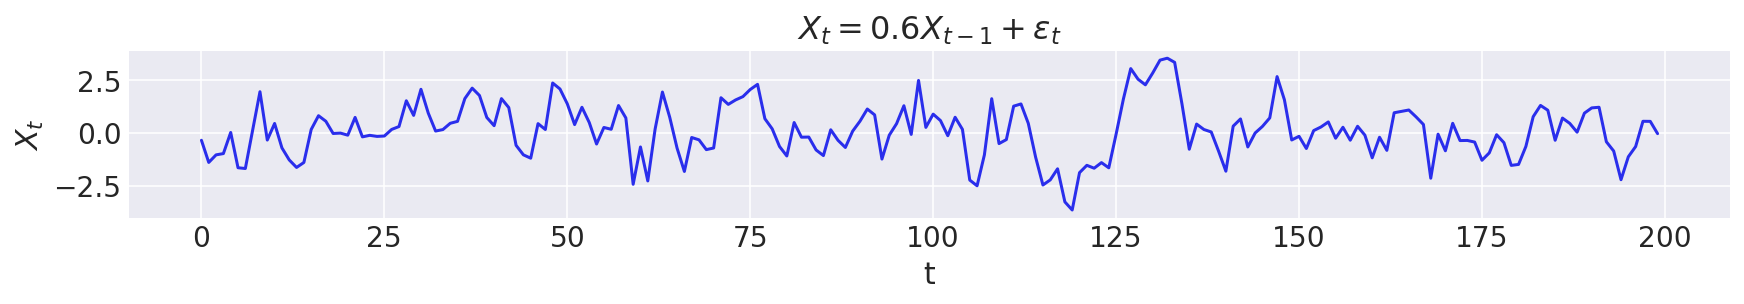

In [6]:
plt.figure(figsize=(12,2))
plt.plot(data[:200])
plt.xlabel('t')
plt.ylabel('$X_t$')
plt.title('$X_t = 0.6X_{t-1} + \epsilon_t$')

In [8]:
# prepare data
tmpdf = pd.DataFrame.from_dict({'X':data})
tmpdf['lag_1'] = tmpdf['X'].shift()
tmpdf.dropna(inplace=True)
X = tmpdf[['X']].values
X_lags = tmpdf.drop(['X'], axis=1).values

In [14]:
with pm.Model() as ar1_model:
    intercept = pm.Uniform('intercept', -10, 10)
    lag_coefs = pm.Uniform('lag_coefs', -10, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    
    mu = intercept + lag_coefs * X_lags
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X)
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'lag_coefs'}>,
        <AxesSubplot:title={'center':'lag_coefs'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

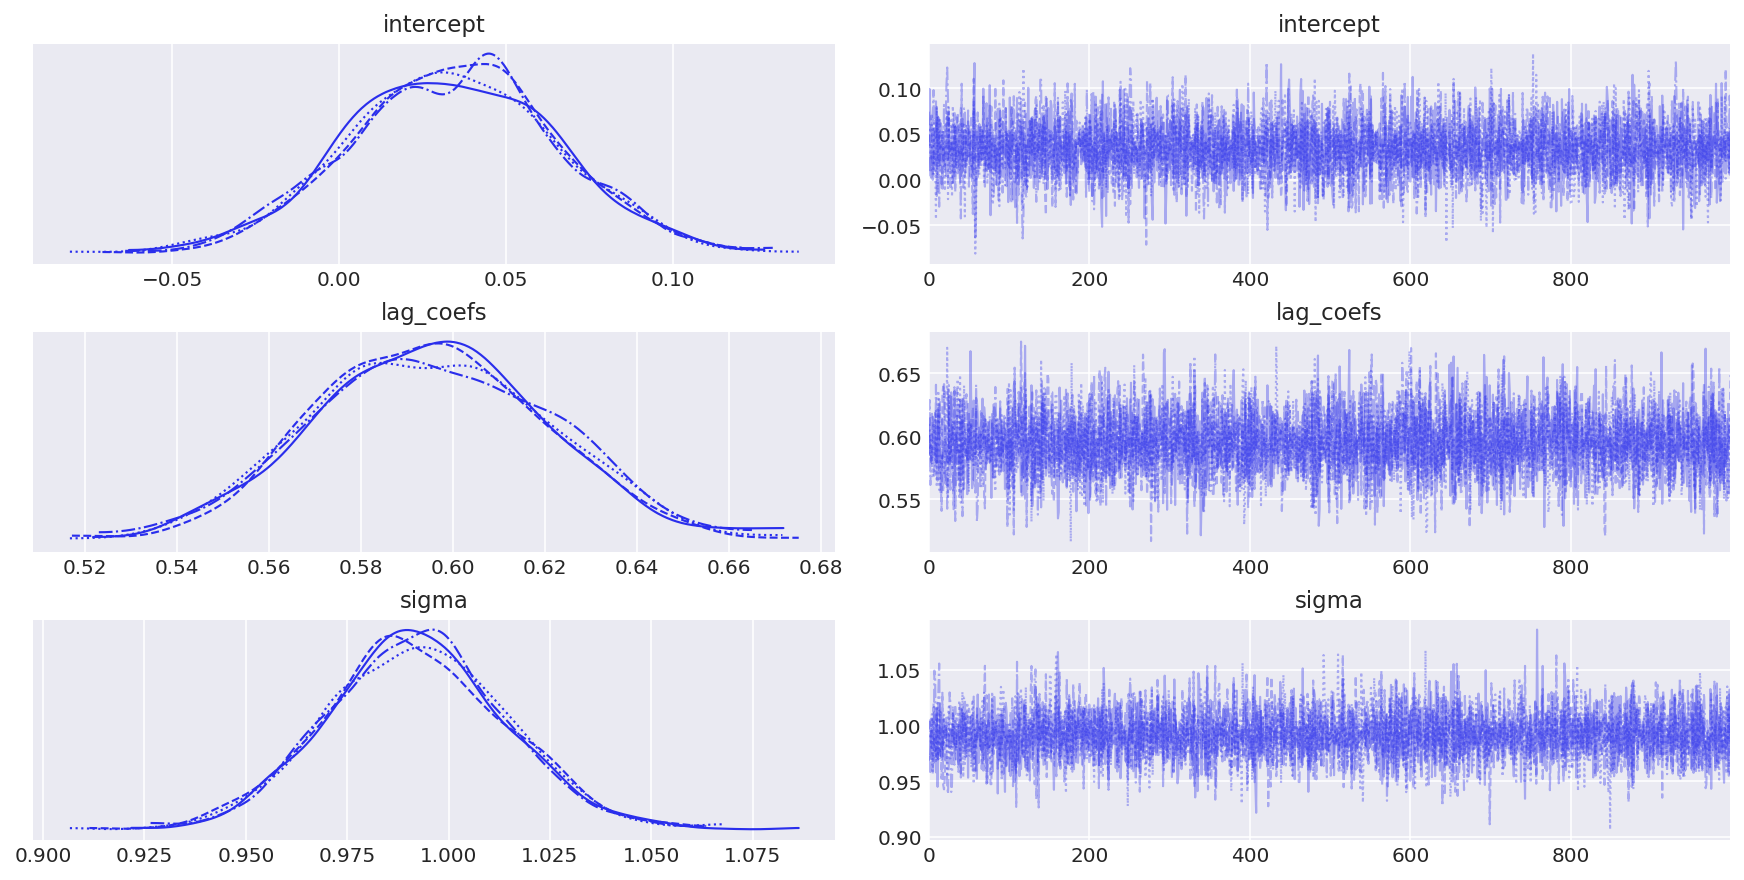

In [15]:
az.plot_trace(idata)

In [16]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.034  0.031  -0.022    0.094        0.0      0.0    6778.0   
lag_coefs  0.595  0.026   0.549    0.643        0.0      0.0    6242.0   
sigma      0.992  0.022   0.953    1.034        0.0      0.0    6410.0   

           ess_tail  r_hat  
intercept    3523.0    1.0  
lag_coefs    2931.0    1.0  
sigma        3533.0    1.0

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

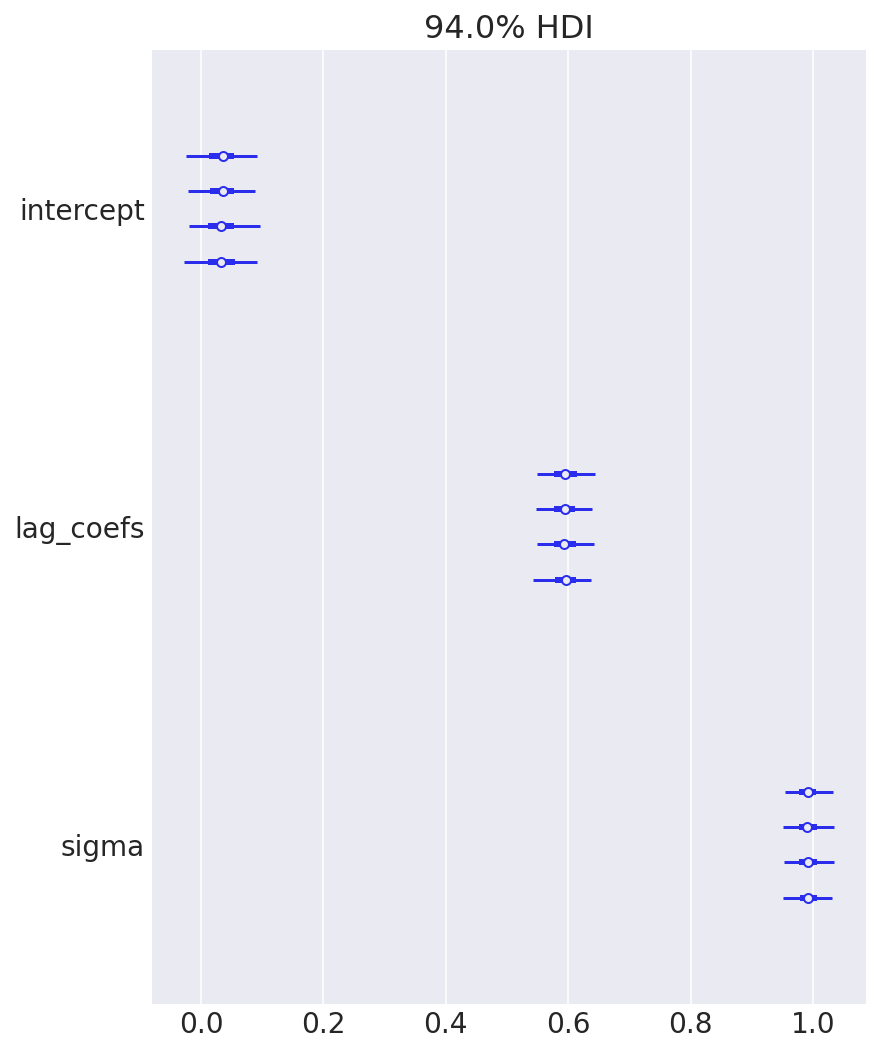

In [17]:
az.plot_forest(idata)

### AR(2)

In [40]:
np.random.seed(5)
data,roots = generate_ar(1, [0.6, 0.3], return_roots=True)
print(roots)

[0.3244998 0.9244998]


Text(0.5, 1.0, '$X_t = 0.6X_{t-1} + 0.3X_{t-2} + \\epsilon_t$')

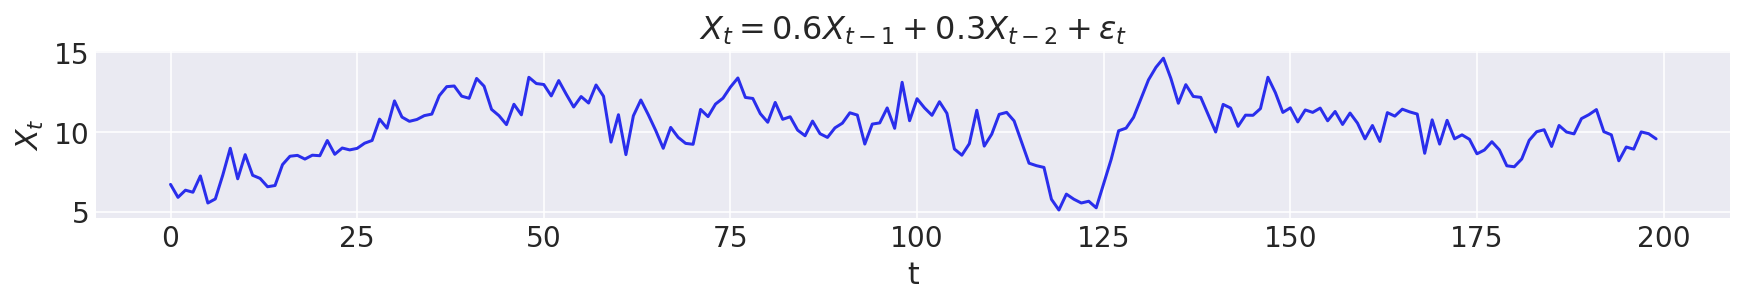

In [41]:
plt.figure(figsize=(12,2))
plt.plot(data[:200])
plt.xlabel('t')
plt.ylabel('$X_t$')
plt.title('$X_t = 0.6X_{t-1} + 0.3X_{t-2} + \epsilon_t$')

In [42]:
from statsmodels.tsa.ar_model import AutoReg

for i in range(1,6):
    res = AutoReg(data, lags=i).fit()
    print(f'{i} lags: BIC = {res.bic}')

1 lags: BIC = 2938.0094966780625
2 lags: BIC = 2838.788815313516
3 lags: BIC = 2843.790174185046
4 lags: BIC = 2848.5906500053416
5 lags: BIC = 2853.2681722582915


In [43]:
tmpdf = pd.DataFrame.from_dict({'X':data})
tmpdf['lag_1'] = tmpdf['X'].shift()
tmpdf['lag_2'] = tmpdf['X'].shift(2)
tmpdf.dropna(inplace=True)
X = tmpdf[['X']].values
X_lags = tmpdf.drop(['X'], axis=1).values

In [44]:
with pm.Model() as ar_model:
    intercept = pm.Uniform('intercept', -10, 10)
    lag_coefs = pm.Uniform('lag_coefs', -10, 10, shape=X_lags.shape[1])
    sigma = pm.Uniform('sigma', 0, 10)
    
    mu = intercept + pm.math.sum(lag_coefs * X_lags, axis=1)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X[:,0])
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'lag_coefs'}>,
        <AxesSubplot:title={'center':'lag_coefs'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

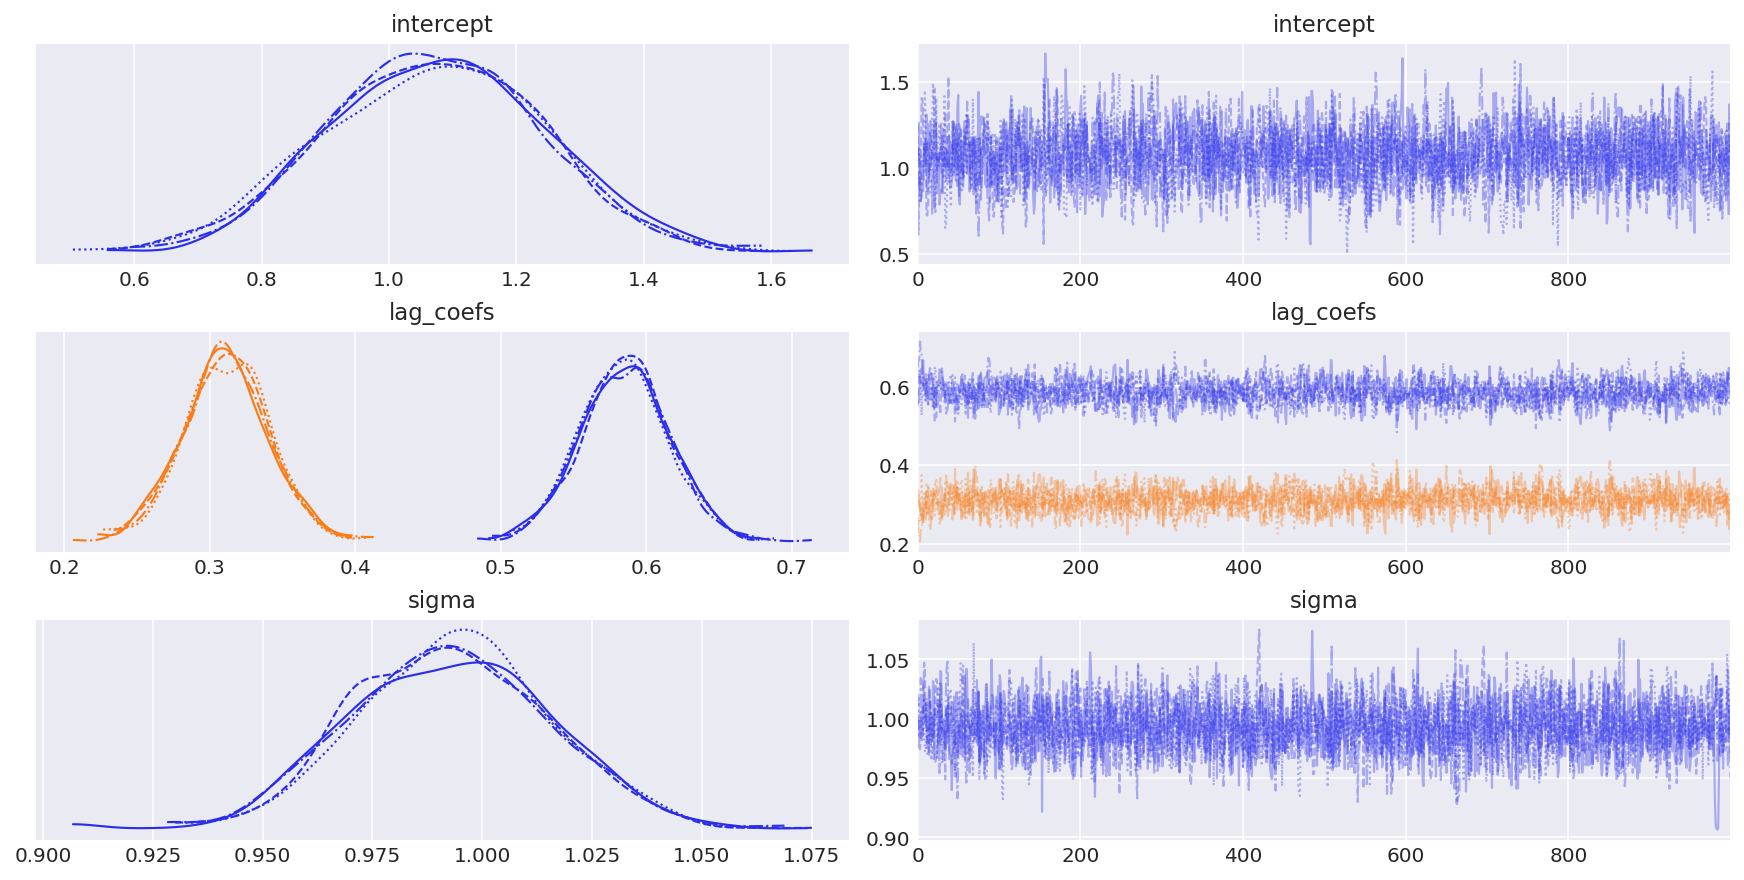

In [45]:
az.plot_trace(idata)

In [46]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept     1.072  0.169   0.769    1.401      0.003    0.002    2350.0   
lag_coefs[0]  0.585  0.030   0.525    0.639      0.001    0.001    1582.0   
lag_coefs[1]  0.311  0.029   0.254    0.364      0.001    0.001    1585.0   
sigma         0.993  0.022   0.953    1.035      0.000    0.000    2938.0   

              ess_tail  r_hat  
intercept       2403.0    1.0  
lag_coefs[0]    1972.0    1.0  
lag_coefs[1]    2077.0    1.0  
sigma           2433.0    1.0

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

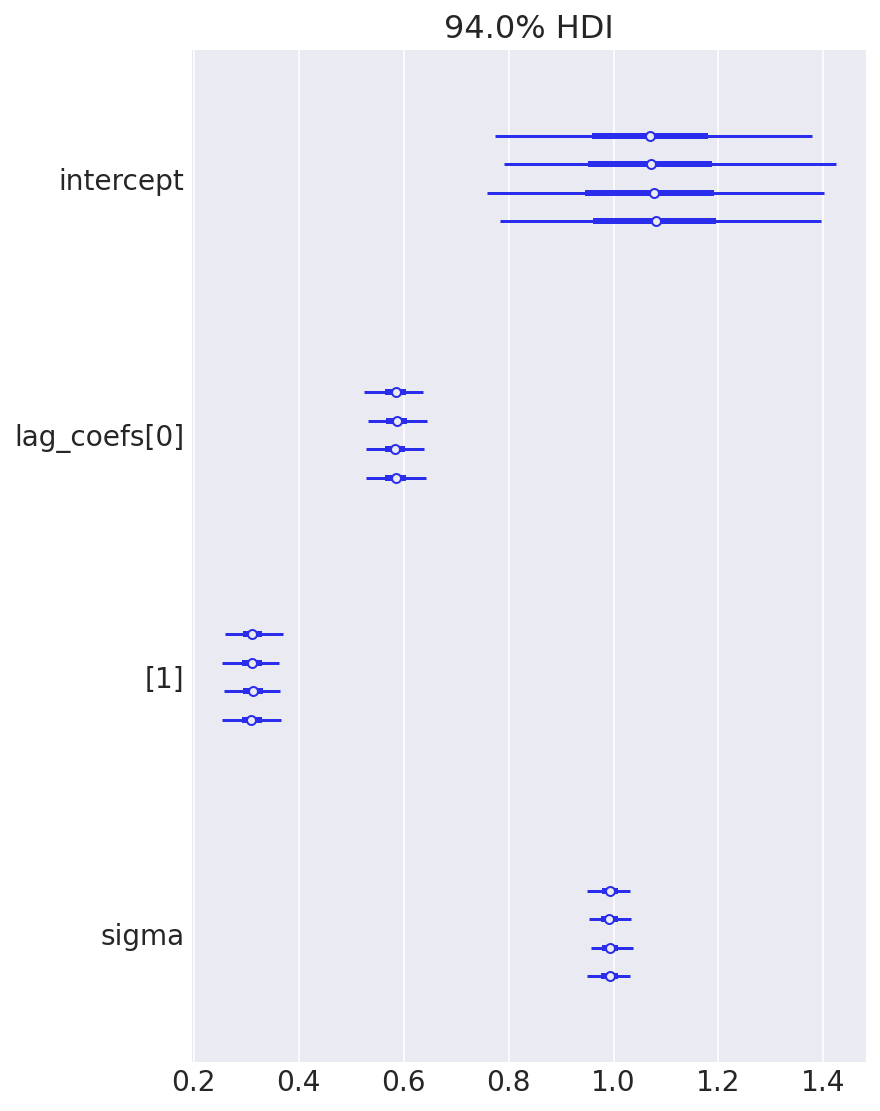

In [47]:
az.plot_forest(idata)

In [48]:
num_chains = len(idata.posterior.chain)
num_draws = len(idata.posterior.draw)
roots = np.zeros((num_chains,num_draws))

for c in range(num_chains):
    for d in range(num_draws):
        coefs = [1] + list(-idata.posterior['lag_coefs'][c][d].values)
        rts = sorted(abs(1/np.polynomial.polynomial.Polynomial(coefs).roots())) # reciprocal roots
        roots[c,d] = rts[-1] # largest reciprocal root in absolute value

array([[<AxesSubplot:title={'center':'root'}>,
        <AxesSubplot:title={'center':'root'}>]], dtype=object)

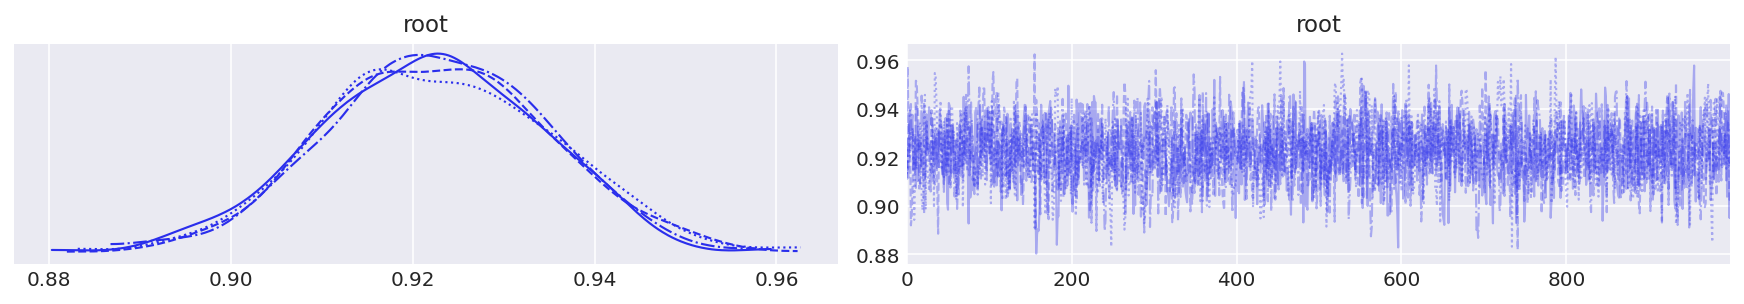

In [49]:
az.plot_trace({'root':roots})

In [50]:
az.summary({'root':roots})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
root  0.922  0.012     0.9    0.946        0.0      0.0    2393.0    2274.0   

      r_hat  
root    1.0

In [51]:
roots.max()

0.9627376371038725

### Integrated AR(3)

In [53]:
np.random.seed(5)
data,roots = generate_ar(1, [0.9,0.22,-0.12], return_roots=True)
roots

array([0.4, 1. , 0.3])

In [54]:
for i in range(1,6):
    res = AutoReg(data, lags=i).fit()
    print(f'{i} lags: BIC = {res.bic}')

1 lags: BIC = 2866.5692956423136
2 lags: BIC = 2852.864773634938
3 lags: BIC = 2842.8778364903933
4 lags: BIC = 2847.787885358511
5 lags: BIC = 2852.1863800450524


In [55]:
tmpdf = pd.DataFrame.from_dict({'X':data})
tmpdf['lag_1'] = tmpdf['X'].shift()
tmpdf['lag_2'] = tmpdf['X'].shift(2)
tmpdf['lag_3'] = tmpdf['X'].shift(3)
tmpdf.dropna(inplace=True)
X = tmpdf[['X']].values
X_lags = tmpdf.drop(['X'], axis=1).values

In [56]:
with pm.Model() as ar_model:
    intercept = pm.Uniform('intercept', -10, 10)
    lag_coefs = pm.Uniform('lag_coefs', -10, 10, shape=X_lags.shape[1])
    sigma = pm.Uniform('sigma', 0, 10)
    
    mu = intercept + pm.math.sum(lag_coefs * X_lags, axis=1)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X[:,0])
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 372 seconds.
The acceptance probability does not match the target. It is 0.9076, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9338, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'lag_coefs'}>,
        <AxesSubplot:title={'center':'lag_coefs'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

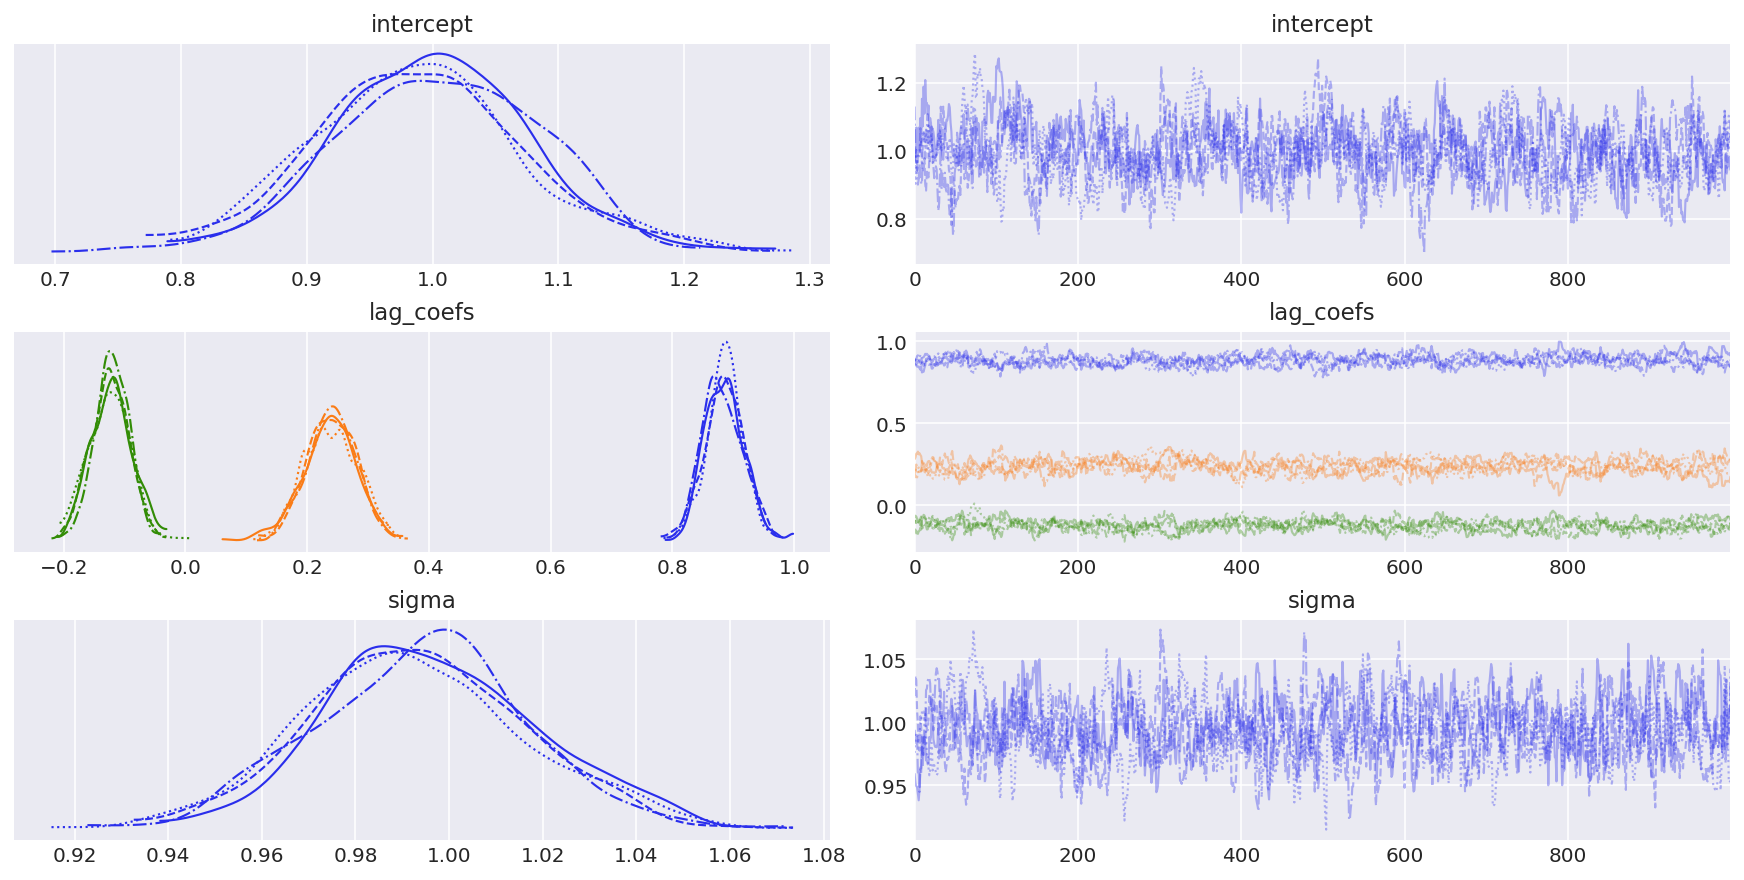

In [57]:
az.plot_trace(idata)

In [58]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept     0.996  0.083   0.848    1.160      0.005    0.003     302.0   
lag_coefs[0]  0.884  0.032   0.824    0.941      0.002    0.001     234.0   
lag_coefs[1]  0.239  0.042   0.159    0.316      0.003    0.002     186.0   
lag_coefs[2] -0.123  0.032  -0.182   -0.061      0.002    0.002     212.0   
sigma         0.994  0.023   0.952    1.039      0.001    0.001     352.0   

              ess_tail  r_hat  
intercept        460.0   1.01  
lag_coefs[0]     555.0   1.02  
lag_coefs[1]     319.0   1.01  
lag_coefs[2]     479.0   1.01  
sigma            799.0   1.01

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

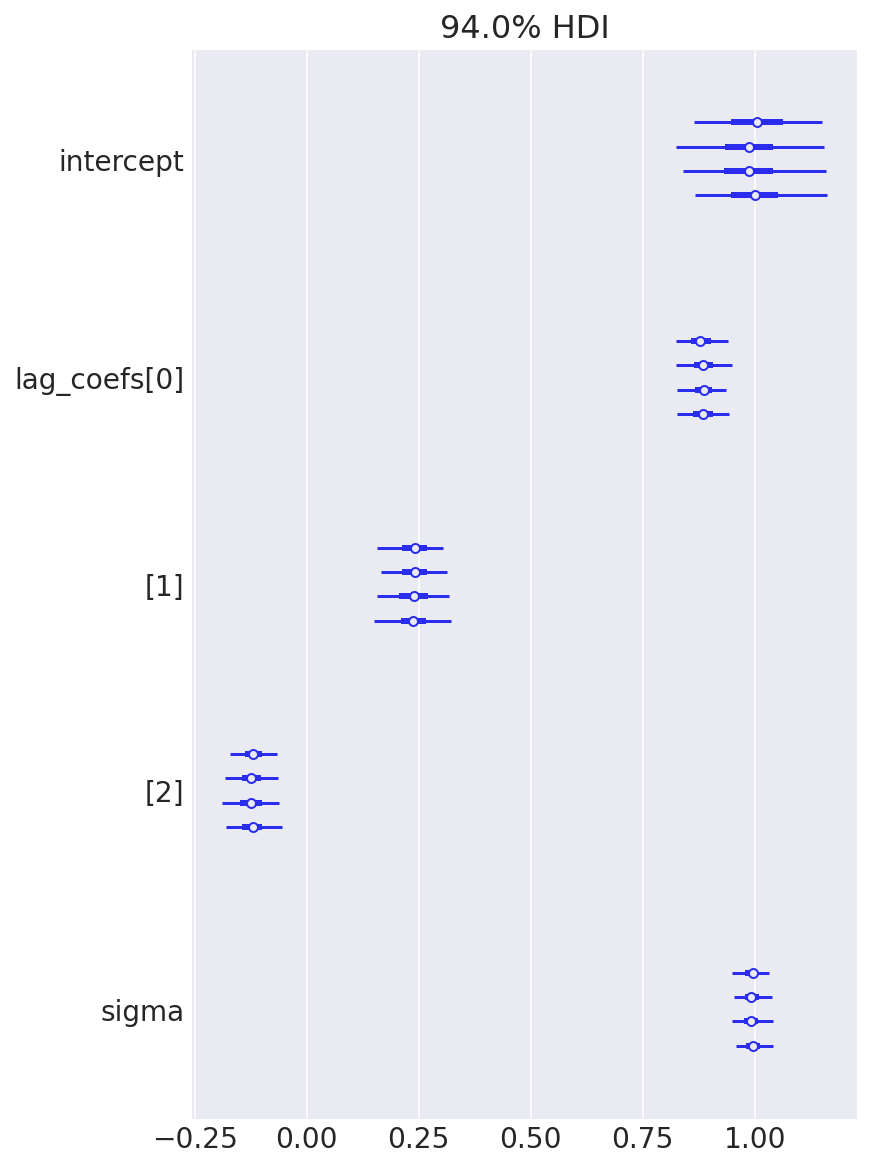

In [59]:
az.plot_forest(idata)

In [60]:
num_chains = len(idata.posterior.chain)
num_draws = len(idata.posterior.draw)
roots = np.zeros((num_chains,num_draws))

for c in range(num_chains):
    for d in range(num_draws):
        coefs = [1] + list(-idata.posterior['lag_coefs'][c][d].values)
        rts = sorted(abs(1/np.polynomial.polynomial.Polynomial(coefs).roots())) # reciprocal roots
        roots[c,d] = rts[-1] # largest reciprocal root in absolute value

array([[<AxesSubplot:title={'center':'root'}>,
        <AxesSubplot:title={'center':'root'}>]], dtype=object)

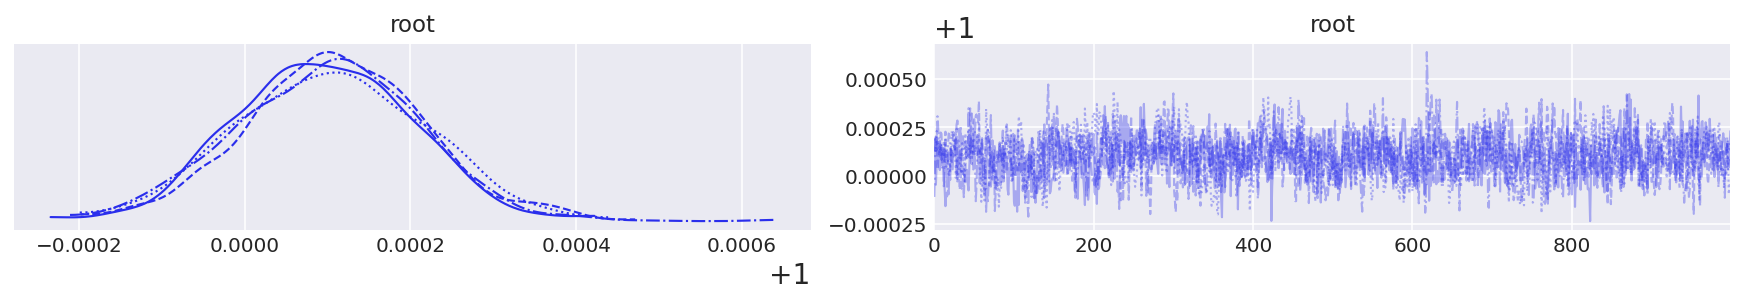

In [61]:
az.plot_trace({'root':roots})

In [64]:
az.summary({'root':roots}, round_to=4)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
root  1.0001  0.0001  0.9999   1.0003        0.0      0.0  654.7783   

       ess_tail   r_hat  
root  1399.5516  1.0032

# VAR(p)

In [65]:
from statsmodels.tsa.statespace.tools import companion_matrix

def generate_var(intercept, lag_coefs, eps, size=1000, return_evals=False):
    '''
    Generate a sample from d-dimensional VAR(p) process with given parameters
    Order p is equal to the number of lag coefficients

    Args:
        intercept (numpy.ndarray): value of intercept with shape (p,)
        lag_coef (numpy.ndarray): values of lag coefficients with shape (p,d,d)
        eps (numpy.ndarray): standard deviation of random noise terms with shape (p,)
        size (int): length of sample to generate
        return_evals (boolean): whether to return the eigenvalues of companion matrix

    Returns:
        numpy.ndarray: generated sample (size,)
        list: eigenvalues of companions matrix (absolute values)
    '''
    
    num_vars = lag_coefs.shape[1]
    lags = lag_coefs.shape[0]
    warmup = lags+10
    
    x = np.zeros([warmup+size, num_vars])
    x[:lags+1] = intercept
    
    for i in range(lags+1, len(x)):
        # prepare array of lagged variables
        lagged_vals = x[i-1:i-1-lags:-1]
        
        # calculate current value
        cs = {}
        for d in range(num_vars):
            cs[d] = intercept[d] + (lag_coefs[:,d,:]*lagged_vals).sum() + eps[d]*np.random.randn() 
        x[i] = np.hstack([cs[d] for d in range(num_vars)])

    x = x[warmup:]

    if return_evals:
        # construct companion matrix
        cm = companion_matrix([1] + [lag_coefs[i] for i in range(lags)])
        # calculate eigenvalues and their absolute value
        evals = np.linalg.eig(cm)[0] 
        evals_abs = np.abs(evals)      
        return x, evals_abs
    
    else:
        return x

### VAR(1)

In [66]:
intercept_true = np.array([1,1])
lag_coefs_true = np.array([[[0.6,0], [0,0.3]]])
sigma_true = np.array([1,1])

In [67]:
np.random.seed(5)
data, evals = generate_var(intercept_true, lag_coefs_true, sigma_true, return_evals=True)

In [68]:
evals

array([0.6, 0.3])

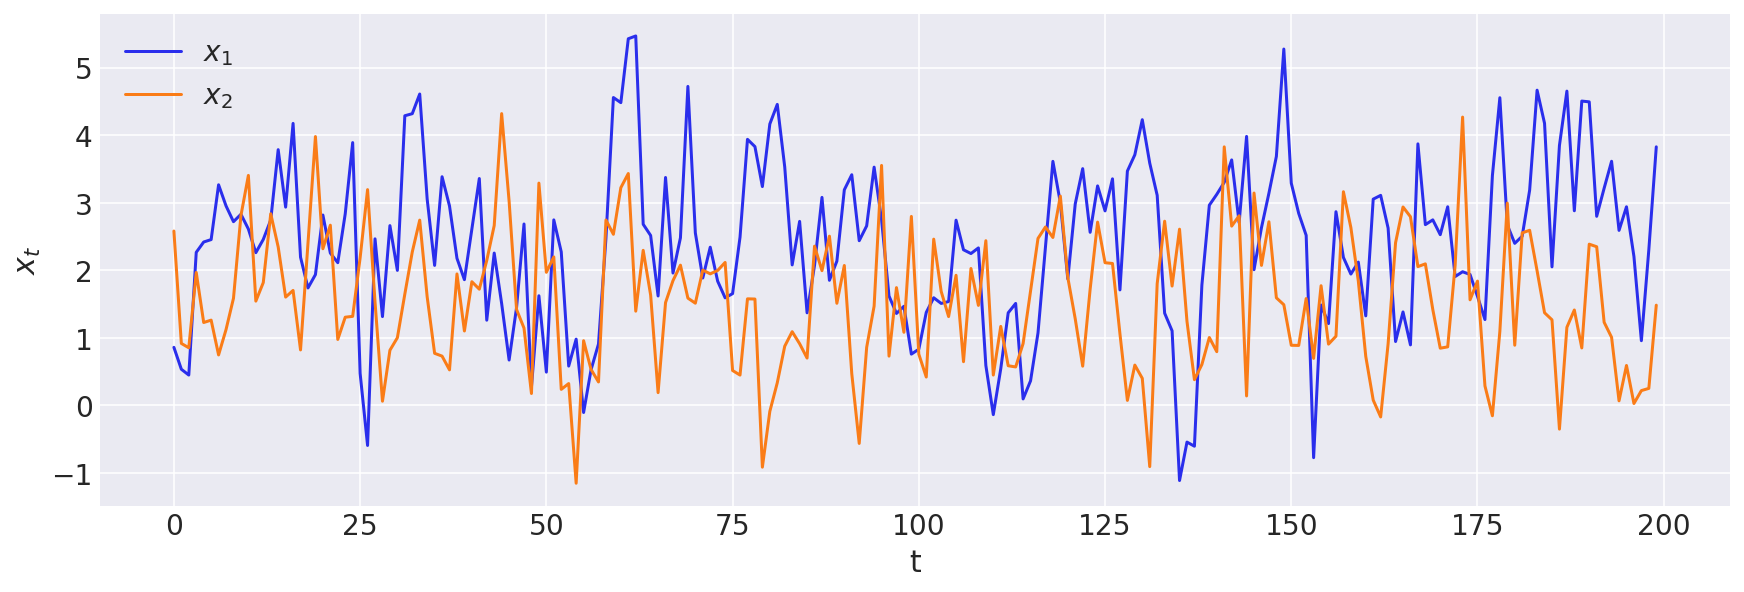

In [69]:
plt.figure(figsize=(12,4))
plt.plot(data[:200,0], label='$x_1$') # plot first 200 datapoints
plt.plot(data[:200,1], label='$x_2$')
plt.xlabel('t')
plt.ylabel('$x_t$')
plt.legend()

In [70]:
# prepare data
tmpdf = pd.DataFrame.from_dict({'x1':data[:,0], 'x2':data[:,1]})
tmpdf['x1_lag1'] = tmpdf['x1'].shift(1)
tmpdf['x2_lag1'] = tmpdf['x2'].shift(1)
tmpdf.dropna(inplace=True)

X = tmpdf[['x1','x2']].values
X_lags = tmpdf.drop(['x1','x2'], axis=1).values

In [71]:
# define model
coords = {
    'lags': range(1,2), 
    'vars': ('x1','x2'),
    'cross_vars': ('x1','x2'),
    'time': range(len(X))
}

with pm.Model(coords=coords) as model:
    intercept = pm.Uniform('intercept', -10, 10, dims=('vars'))
    lag_coefs = pm.Uniform('lag_coefs', -10, 10, dims=('lags','vars','cross_vars'))
    sigma = pm.Uniform('sigma', 0, 10, dims=('vars'))
    
    mu0 = intercept[0] + pm.math.sum(pm.math.flatten(lag_coefs[:,0,:]) * X_lags, axis=1)
    mu1 = intercept[1] + pm.math.sum(pm.math.flatten(lag_coefs[:,1,:]) * X_lags, axis=1)
    mu = pm.math.stack([mu0,mu1], axis=1)
    
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X, dims=('time','vars'))
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'lag_coefs'}>,
        <AxesSubplot:title={'center':'lag_coefs'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

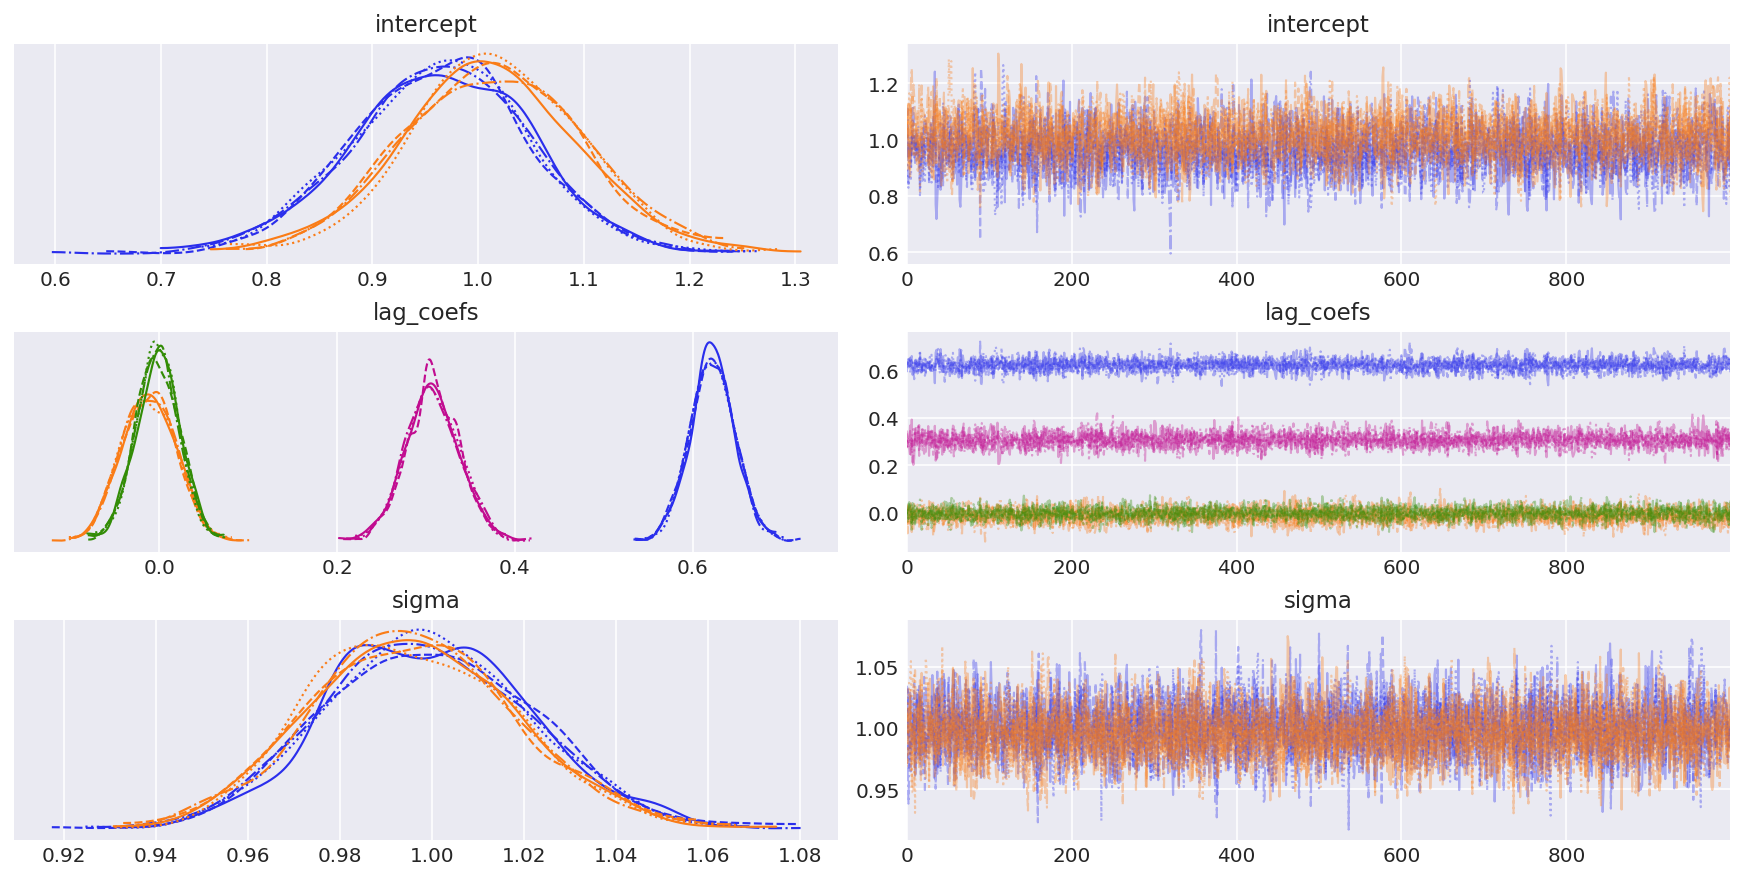

In [72]:
az.plot_trace(idata)

In [73]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept[x1]         0.964  0.083   0.815    1.125      0.001    0.001   
intercept[x2]         1.013  0.083   0.862    1.175      0.001    0.001   
lag_coefs[1, x1, x1]  0.622  0.025   0.573    0.668      0.000    0.000   
lag_coefs[1, x1, x2] -0.012  0.030  -0.066    0.044      0.000    0.000   
lag_coefs[1, x2, x1] -0.002  0.024  -0.049    0.042      0.000    0.000   
lag_coefs[1, x2, x2]  0.307  0.030   0.250    0.364      0.000    0.000   
sigma[x1]             0.999  0.023   0.957    1.041      0.000    0.000   
sigma[x2]             0.996  0.022   0.958    1.040      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
intercept[x1]           3284.0    2925.0    1.0  
intercept[x2]           3337.0    2081.0    1.0  
lag_coefs[1, x1, x1]    3866.0    2904.0    1.0  
lag_coefs[1, x1, x2]    4227.0    2906.0    1.0  
lag_coefs[1, x2, x1]    3667.0    2628.0    1.0  
lag_coefs[1, x2, x2]    4262.0    2948.0    1.0  
sigma[x1]               4241.0    2942.0    1.0  
sigma[x2]               4394.0    2787.0    1.0

array([[<AxesSubplot:title={'center':'lag_coefs\n1, x1, x1'}>,
        <AxesSubplot:title={'center':'lag_coefs\n1, x1, x1'}>],
       [<AxesSubplot:title={'center':'lag_coefs\n1, x1, x2'}>,
        <AxesSubplot:title={'center':'lag_coefs\n1, x1, x2'}>],
       [<AxesSubplot:title={'center':'lag_coefs\n1, x2, x1'}>,
        <AxesSubplot:title={'center':'lag_coefs\n1, x2, x1'}>],
       [<AxesSubplot:title={'center':'lag_coefs\n1, x2, x2'}>,
        <AxesSubplot:title={'center':'lag_coefs\n1, x2, x2'}>]],
      dtype=object)

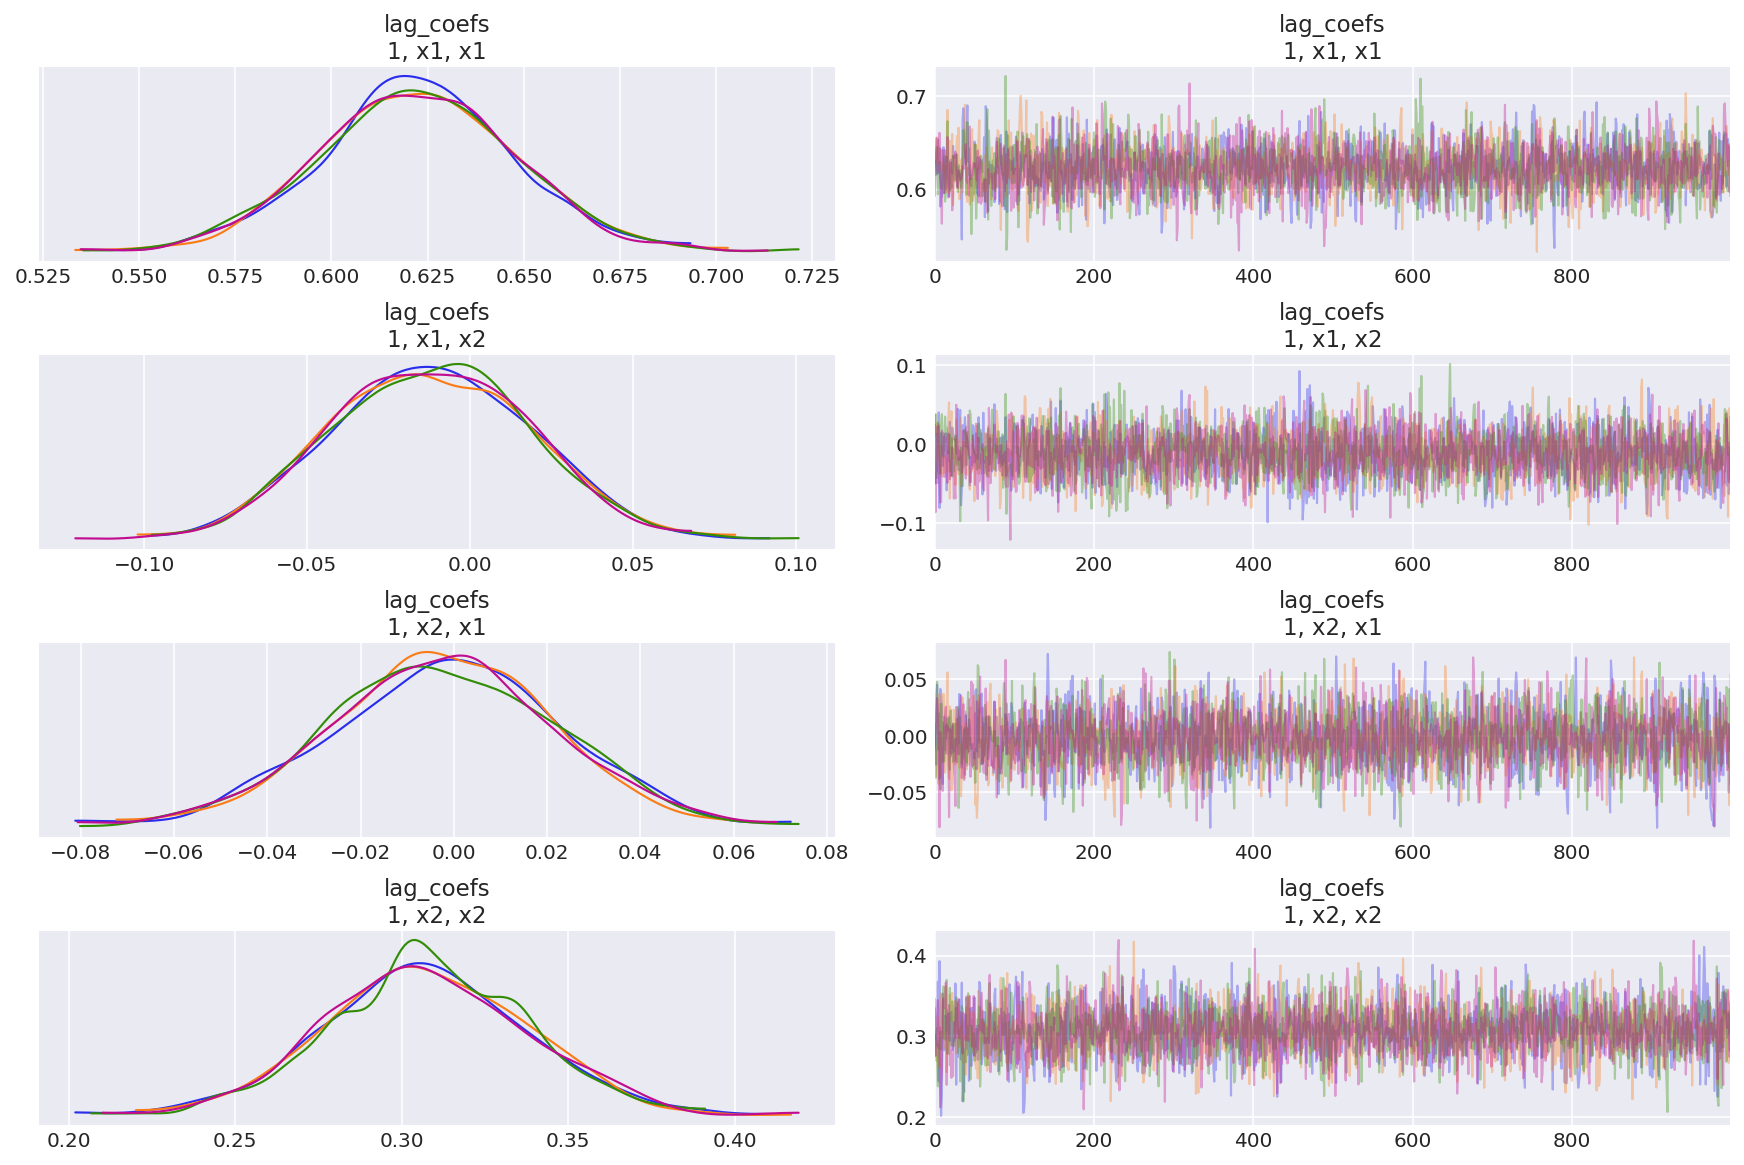

In [74]:
# plot distributions of each coefficent individually
az.plot_trace(idata, var_names=['lag_coefs'], compact=False)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

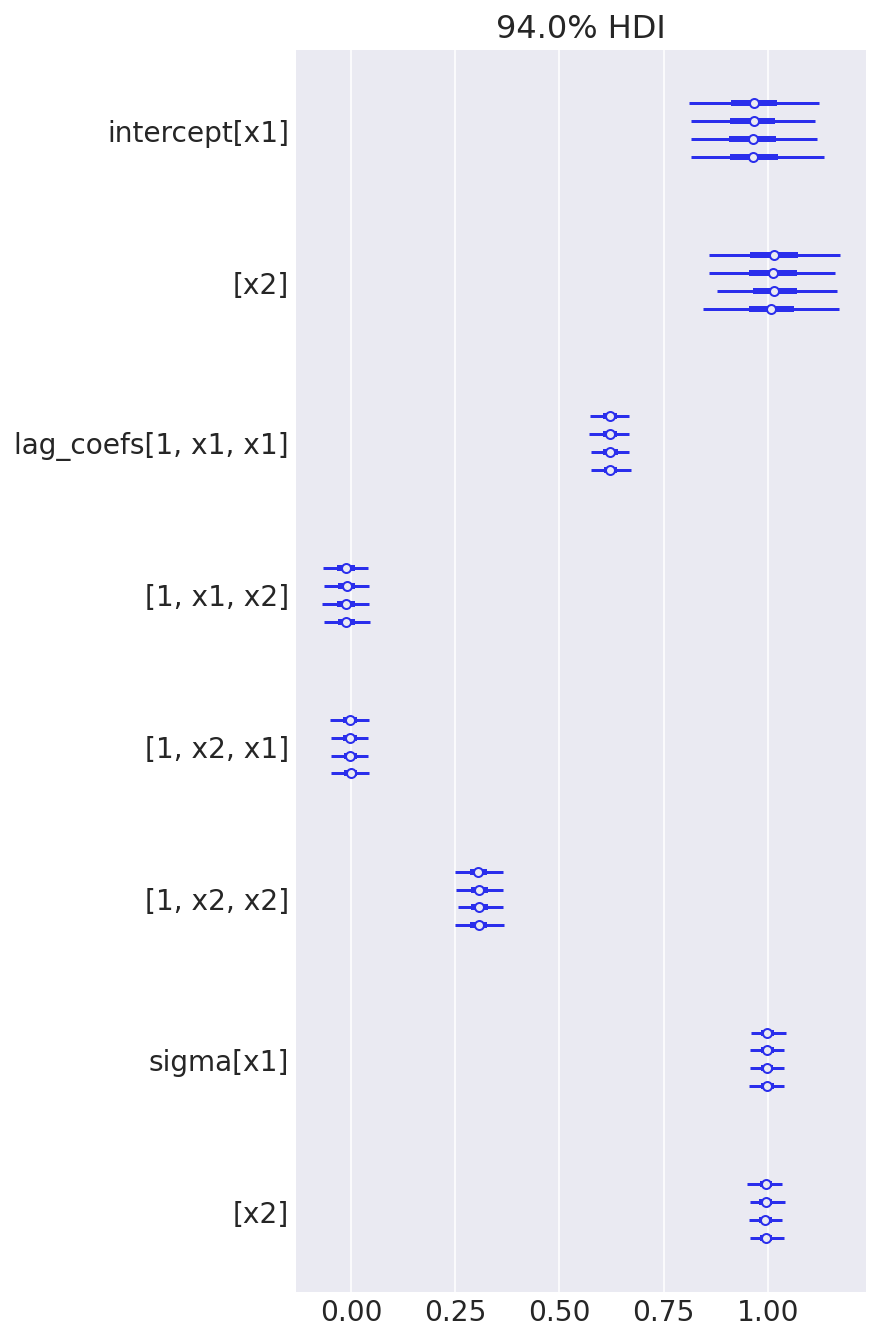

In [75]:
az.plot_forest(idata)

### Cointegrated VAR example

In [76]:
alpha_true = np.array([1,2,0])
beta_true = np.array([[[0.7,0,0.5],[0,0.4,0.25],[0,0,1]]])
eps_true = np.array([1,1,2])

np.random.seed(5)
data, evals = generate_var(alpha_true, beta_true, eps_true, return_evals=True)
evals

array([1. , 0.7, 0.4])

In [77]:
from statsmodels.tsa.stattools import adfuller

print('ADF test x1: pvalue = ', adfuller(data[:,0])[1])
print('ADF test x2: pvalue = ', adfuller(data[:,1])[1])
print('ADF test diff(x1): pvalue = ', adfuller(np.diff(data[:,0]))[1])
print('ADF test diff(x2): pvalue = ', adfuller(np.diff(data[:,1]))[1])

ADF test x1: pvalue =  0.9403982647532322
ADF test x2: pvalue =  0.8362823617017554
ADF test diff(x1): pvalue =  2.15570422326447e-27
ADF test diff(x2): pvalue =  0.0


In [78]:
from statsmodels.tsa.stattools import coint

print('Engle-Granger cointegration test x1,x2: pvalue = ', coint(data[:,0], data[:,1])[1])

Engle-Granger cointegration test x1,x2: pvalue =  2.4144822402860336e-29


In [79]:
# prepare data
tmpdf = pd.DataFrame.from_dict({'x1':data[:,0], 'x2':data[:,1]})
tmpdf['x1_lag1'] = tmpdf['x1'].shift(1)
tmpdf['x2_lag1'] = tmpdf['x2'].shift(1)
tmpdf.dropna(inplace=True)
tmpdf

x1         x2    x1_lag1    x2_lag1
1    13.158229   5.132144  12.323652   5.986014
2    12.842117   5.366762  13.158229   5.132144
3    13.168784   6.972374  12.842117   5.366762
4    14.674448   5.930480  13.168784   6.972374
5    13.789887   5.936148  14.674448   5.930480
..         ...        ...        ...        ...
995 -78.297613 -17.691348 -76.531054 -18.490357
996 -80.771421 -17.928800 -78.297613 -17.691348
997 -81.375670 -18.809800 -80.771421 -17.928800
998 -81.069497 -17.509605 -81.375670 -18.809800
999 -84.229568 -18.629264 -81.069497 -17.509605

[999 rows x 4 columns]

In [80]:
# test first element for integration
X = tmpdf[['x1']].values
X_lags = tmpdf[['x1_lag1']].values

with pm.Model() as ar_model:
    intercept = pm.Uniform('intercept', -10, 10)
    lag_coefs = pm.Uniform('lag_coefs', -10, 10, shape=X_lags.shape[1])
    sigma = pm.Uniform('sigma', 0, 10)
    
    mu = intercept + pm.math.sum(lag_coefs * X_lags, axis=1)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X[:,0])
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


array([[<AxesSubplot:title={'center':'root'}>,
        <AxesSubplot:title={'center':'root'}>]], dtype=object)

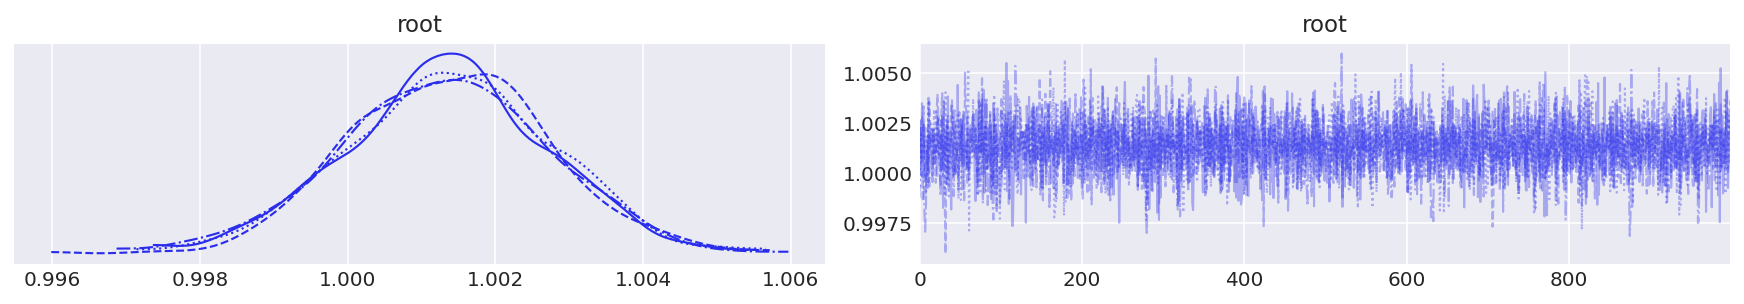

In [81]:
num_chains = len(idata.posterior.chain)
num_draws = len(idata.posterior.draw)
roots = np.zeros((num_chains,num_draws))

for c in range(num_chains):
    for d in range(num_draws):
        coefs = [1] + list(-idata.posterior['lag_coefs'][c][d].values)
        rts = sorted(abs(1/np.polynomial.polynomial.Polynomial(coefs).roots())) # reciprocal roots
        roots[c,d] = rts[-1] # largest reciprocal root in absolute value
        
# plot posterior of the largest root
az.plot_trace({'root':roots})

In [82]:
az.summary({'root':roots})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
root  1.001  0.001   0.999    1.004        0.0      0.0    5871.0    2814.0   

      r_hat  
root    1.0

In [83]:
# test second element for integration
X = tmpdf[['x2']].values
X_lags = tmpdf[['x2_lag1']].values

with pm.Model() as ar_model:
    intercept = pm.Uniform('intercept', -10, 10)
    lag_coefs = pm.Uniform('lag_coefs', -10, 10, shape=X_lags.shape[1])
    sigma = pm.Uniform('sigma', 0, 10)
    
    mu = intercept + pm.math.sum(lag_coefs * X_lags, axis=1)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X[:,0])
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<AxesSubplot:title={'center':'root'}>,
        <AxesSubplot:title={'center':'root'}>]], dtype=object)

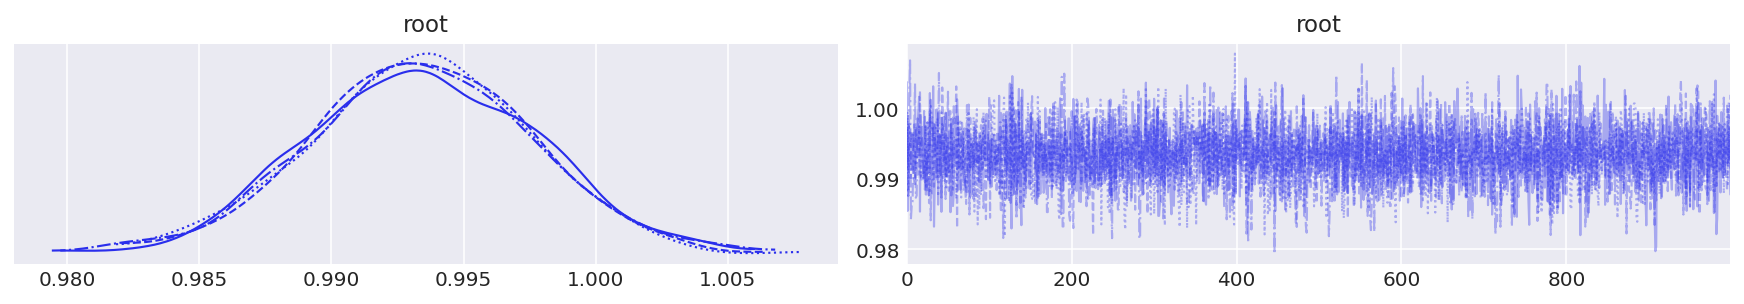

In [84]:
num_chains = len(idata.posterior.chain)
num_draws = len(idata.posterior.draw)
roots = np.zeros((num_chains,num_draws))

for c in range(num_chains):
    for d in range(num_draws):
        coefs = [1] + list(-idata.posterior['lag_coefs'][c][d].values)
        rts = sorted(abs(1/np.polynomial.polynomial.Polynomial(coefs).roots())) # reciprocal roots
        roots[c,d] = rts[-1] # largest reciprocal root in absolute value
        
# plot posterior of the largest root
az.plot_trace({'root':roots})

In [85]:
az.summary({'root':roots})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
root  0.993  0.004   0.986    1.001        0.0      0.0    5589.0    3136.0   

      r_hat  
root    1.0

In [86]:
# fit VAR(1) model
X = tmpdf[['x1','x2']].values
X_lags = tmpdf.drop(['x1','x2'], axis=1).values

coords = {
    'lags': range(1,2), 
    'vars': ('x1','x2'),
    'cross_vars': ('x1','x2'),
    'time': range(len(X))
}

with pm.Model(coords=coords) as model:
    intercept = pm.Uniform('intercept', -10, 10, dims=('vars'))
    lag_coefs = pm.Uniform('lag_coefs', -10, 10, dims=('lags','vars','cross_vars'))
    sigma = pm.Uniform('sigma', 0, 10, dims=('vars'))
    
    mu0 = intercept[0] + pm.math.sum(pm.math.flatten(lag_coefs[:,0,:]) * X_lags, axis=1)
    mu1 = intercept[1] + pm.math.sum(pm.math.flatten(lag_coefs[:,1,:]) * X_lags, axis=1)
    mu = pm.math.stack([mu0,mu1], axis=1)
    
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=X, dims=('time','vars'))
    
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [87]:
# find the distribution of the largest eigenvalue
num_chains = len(idata.posterior.chain)
num_draws = len(idata.posterior.draw)
evals = np.zeros((num_chains,num_draws)) # largest eigenvalue

for c in range(num_chains):
    for d in range(num_draws):
        cm = companion_matrix([1] + [idata.posterior['lag_coefs'][c][d][0].values])
        max_eval = sorted(abs(np.linalg.eig(cm)[0]))[-1]
        evals[c,d] = max_eval

array([[<AxesSubplot:title={'center':'eval'}>,
        <AxesSubplot:title={'center':'eval'}>]], dtype=object)

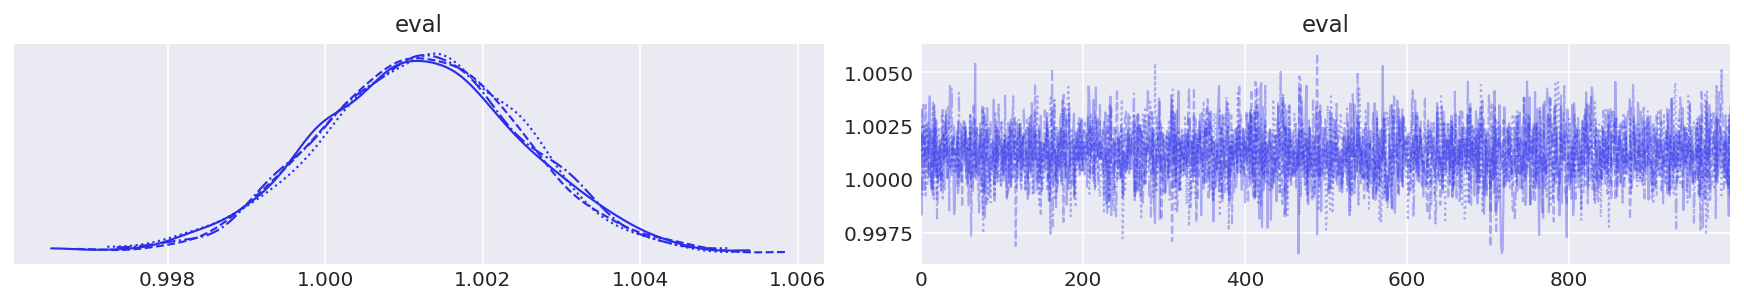

In [88]:
# plot posterior of the largest eigenvalue
az.plot_trace({'eval':evals})

In [89]:
az.summary({'eval':evals})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
eval  1.001  0.001   0.999    1.004        0.0      0.0    3946.0    3130.0   

      r_hat  
eval    1.0